#VENUS nodes

The venus nodes are located in the Georgia Strait. In the grid system set up the East node is at i=283 and j=416 where as the Central node is at i=266 and j=424.


##Plotting the nodes on a map
Here is the location of the nodes.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import netCDF4 as nc
from dateutil import tz
import os
from glob import glob

from salishsea_tools import(viz_tools, tidetools,nc_tools)
from salishsea_tools.nowcast import (analyze, figures)
from IPython.display import Image
import datetime

%matplotlib inline

In [31]:
tracers=nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/01feb15/SalishSea_1d_20150201_20150201_grid_T.nc')
bathya=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

model_depths=tracers.variables['deptht'][:]

bathy=bathya.variables['Bathymetry'][:]
x=bathya.variables['nav_lon'][:]
y=bathya.variables['nav_lat'][:]



The following command loads the most recent data from the VENUS nodes

In [32]:
datas={}; lons={}; lats={}; depths={}
datas['Central'], lons['Central'], lats['Central'], depths['Central']=figures.load_VENUS('Central')
datas['East'], lons['East'], lats['East'], depths['East']=figures.load_VENUS('East')
datas['Central'][['sal','temp']]=datas['Central'][['sal','temp']].astype(float)
datas['East'][['sal','temp']]=datas['East'][['sal','temp']].astype(float)


We can access a nice representation of all the output data in a table by using the following command.

In [33]:
datas['Central'];

Central depth: 300 (m)
East depth: 170 (m)


1.1363636363636362

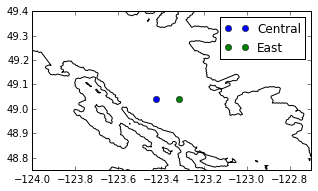

In [34]:
fig, ax=plt.subplots(1,1,figsize=(5,5))
viz_tools.plot_coastline(ax,bathya,coords='map')
for key in ('Central', 'East'):
    ax.plot(lons[key],lats[key],'o',label=key)
    print key, 'depth:', depths[key], '(m)'       
ax.set_xlim([-124, -122.7])
ax.set_ylim([48.75,49.4])
ax.legend(loc='best')
viz_tools.set_aspect(ax)
    

This is where the nodes are located! 

#Comparisons

##Model Velocities at VENUS Nodes
First we need to load all the u , v, w data.

In [35]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [36]:
datetime.date.today()


datetime.date(2015, 5, 11)

In [58]:
run_date=datetime.date(2015, 5, 10)

# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

uvel = results_dataset('1h', 'grid_U', results_dir)
vvel = results_dataset('1h', 'grid_V', results_dir)
wvel = results_dataset('1h', 'grid_W', results_dir)

We will be looking at the velocties at the VENUS Central and East nodes. We first need to unstagger the u and v velocities to have them line up with the T grid which is centered in the middle of the cells. After they are centered at the same point we can rotate our axis to have the North and East velocities. This will enable us to compare the model velocities with the VENUS velocities.

In [51]:
def unstag_rot(u_u, v_v, station):
    """ function to unstagger the model velocities to be centered 
    at the tracers cell center. As well as rotate the model velocities
    to be able to compare them with VENUS observations.
    Station specifies 'East' or 'Central'
    u_u and v_v are the zonal and meridonal velocities from the model.
    returns the E/W and N/S velocities as well as the station location 
    model grid for the vertical velocities.
    """
    if station=='Central':
        i=266
        j=424
        depths=330
    else:
        i=283
        j=416
        depths=170

    #We need to access the u velocity that is between i and i-1
    u_t=(u_u[:, :, j, i-1]+u_u[:, :, j, i])/2
    v_t=(v_v[:, :, j, i]+v_v[:, :, j-1, i])/2
    theta=29 
    theta_rad=theta * np.pi /180

    u_E=u_t * np.cos(theta_rad) - v_t * np.sin(theta_rad)
    v_N=u_t * np.sin(theta_rad) + v_t * np.cos(theta_rad)
    return u_E, v_N, i, j, depths

The following function will show the image from the VENUS ADCP that I have saved from their website.

In [52]:
def plot_ADCP_image(station, imagec, imagee):
    """function to show the images from a VENUS nodes to facilitate the comparison.
    Station specifies 'East' or 'Central'
    imagec and imagee are the Central and East .png image that ahs already been manually uploaded and saved, respectively."""
    
    if station=='Central':
        filenamei=imagec
    else:
        filenamei=imagee
    
    fig2=Image(filename=filenamei)
    
    return fig2
    

In [63]:
def plot_vel_NE_comp(station,uvel, vvel, wvel, imagec, imagee):
    """Function to compare the model velocities to the ADCP images produced by VENUS. This comparison
    does not have consistent colour bars.
    Station specifies 'East' or 'Central'
    uvel, vvel and wvel are the Datasets of the filename with the hourly averages of many variables.
    imagec and imagee are the Central and East .png image that ahs already been manually uploaded and saved, respectively."""
    
    u_u= uvel.variables['vozocrtx']
    v_v= vvel.variables['vomecrty']
    w_w= wvel.variables['vovecrtz']
    dep_t= vvel.variables['depthv']
    dep_w=wvel.variables['depthw']

    u_E, v_N, i, j, dep_s=unstag_rot(u_u, v_v,station)

    fig, (axu, axv, axw)=plt.subplots(3,1,figsize=(16,14))

    #viz_tools.set_aspect(axu)
    timestamp=nc_tools.timestamp(uvel,0)
    cmap=plt.get_cmap('jet')
    axu.invert_yaxis()
    mesh=axu.pcolormesh(np.arange(24),dep_t[:], u_E.transpose(),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axu)
    axu.set_ylim([dep_s,0])
    axu.set_xlim([0,23])
    axu.set_xlabel('Time (h)')
    axu.set_ylabel('Depth (m)')
    axu.set_title('East/West Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

    axv.invert_yaxis()
    mesh=axv.pcolormesh(np.arange(24),dep_t[:], v_N.transpose(),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axv)
    axv.set_ylim([dep_s,0])
    axv.set_xlim([0,23])
    axv.set_xlabel('Time (h)')
    axv.set_ylabel('Depth (m)')
    axv.set_title('North/South Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

    axw.invert_yaxis()
    mesh=axw.pcolormesh(np.arange(24), dep_w[:], w_w[:,:,j,i].transpose(), cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axw)
    axw.set_ylim([dep_s,0])
    axw.set_xlim([0,23])
    axw.set_xlabel('Time (h)')
    axw.set_ylabel('Depth (m)')
    axw.set_title('Vertical Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 
    
    fig2=plot_ADCP_image(station, imagec, imagee)
    return fig2

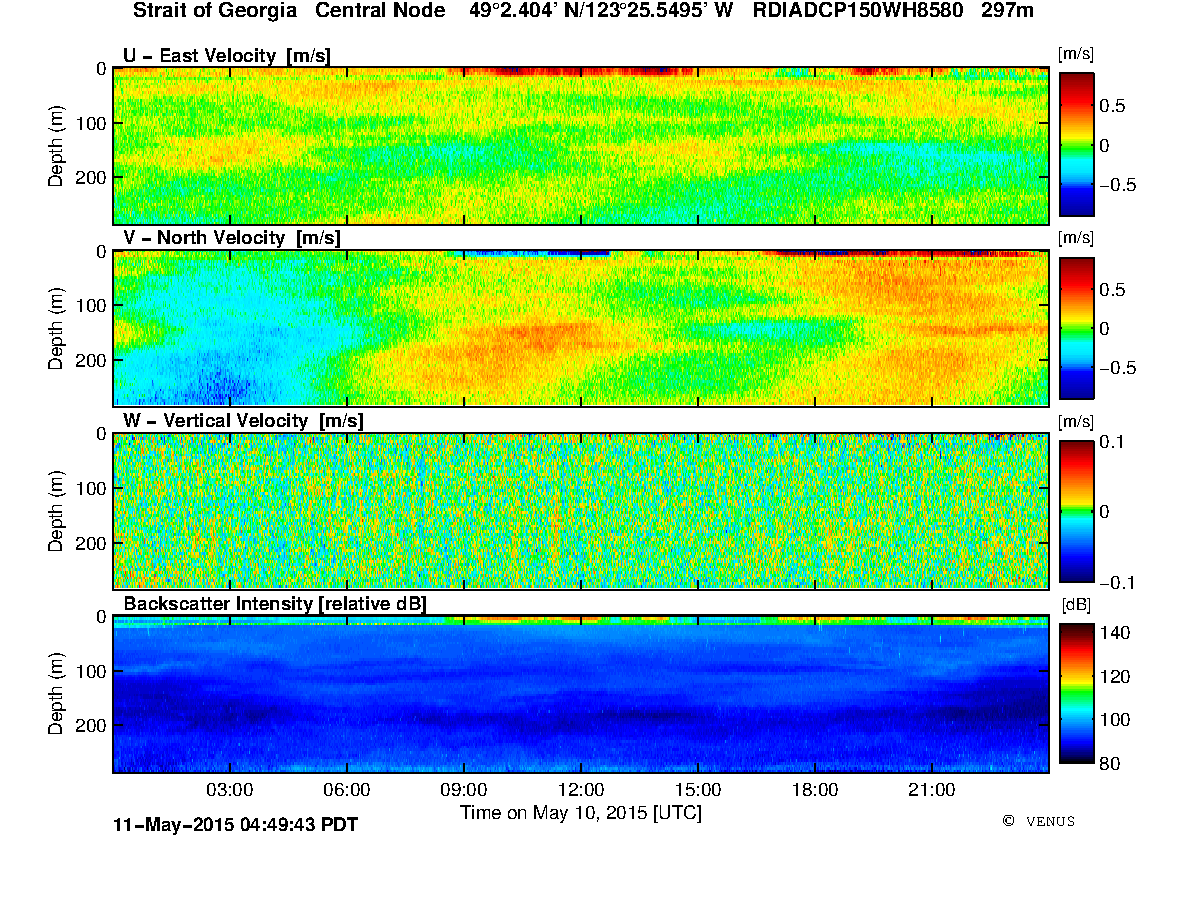

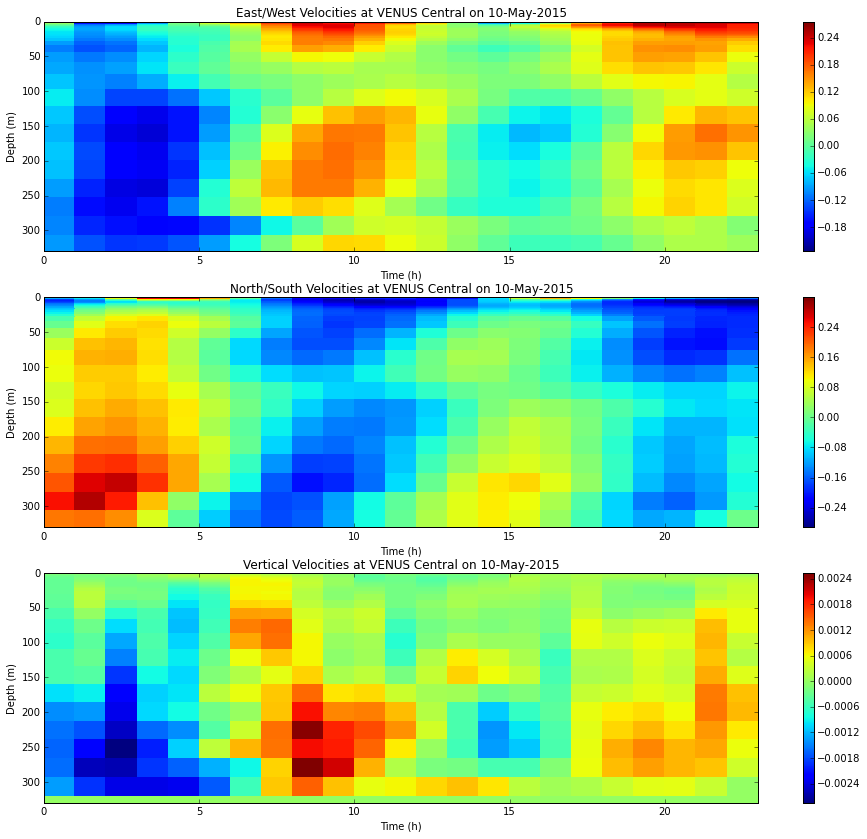

In [64]:
imagec='/home/mdunn/Pictures/VENUS_Central_10may2015_currents.png'
imagee='/home/mdunn/Pictures/VENUS_East_10may2015_currents.png'

plot_vel_NE_comp('Central', uvel, vvel, wvel,imagec, imagee)

From this comparison we can observe that the VENUS ADCP data is showing that the North velocities at the Central node is going opposite ours. Their East velocities seem to have no particular pattern.

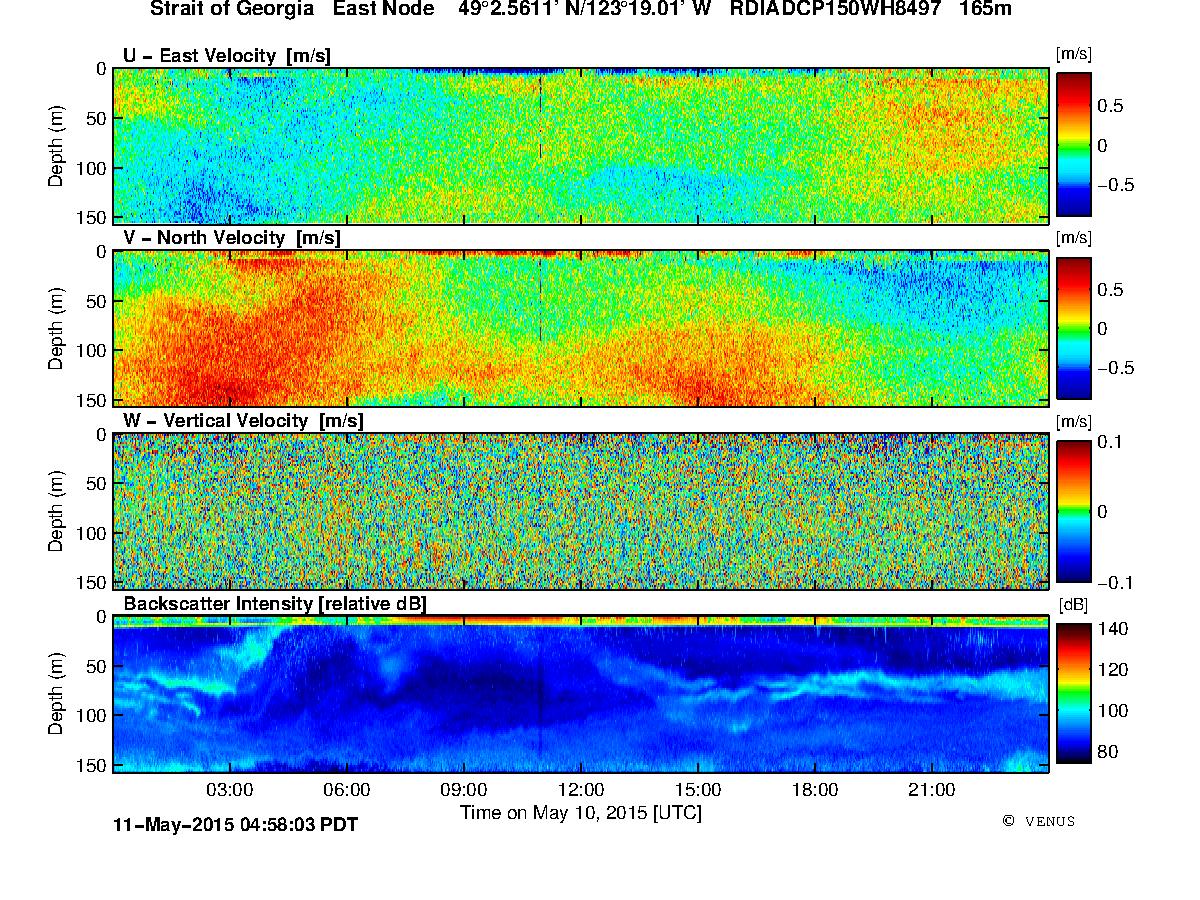

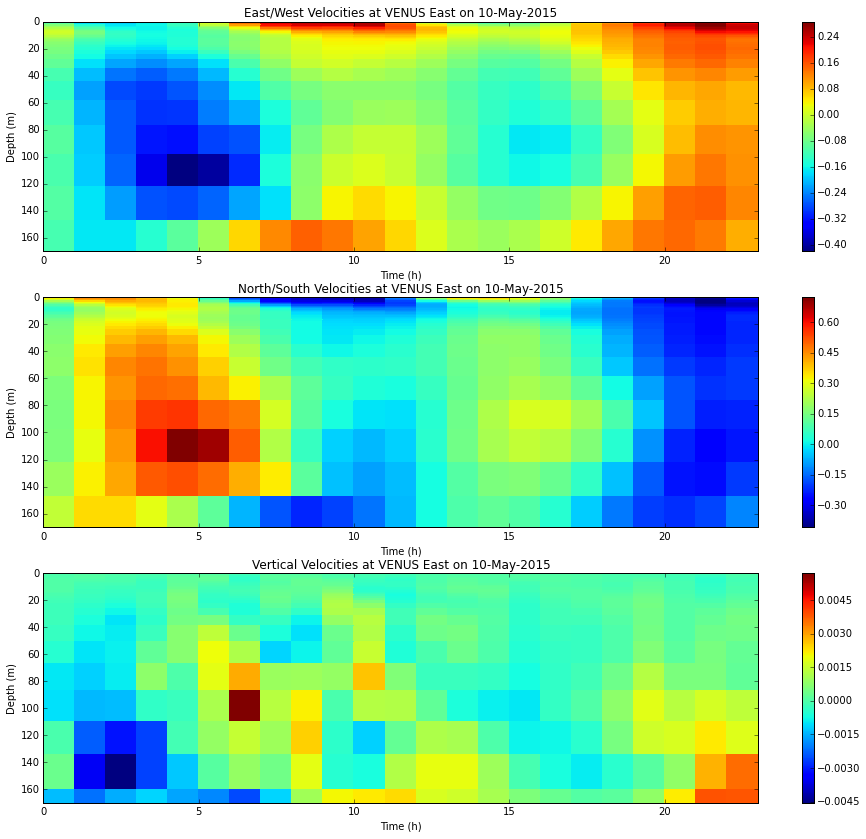

In [42]:
plot_vel_NE_comp('East', uvel, vvel, wvel,imagec, imagee)

The East node velocities have similar patterns.

Now will adjust the colourbar to be the same, this will give a better comparison.

In [45]:
def plot_vel_NE_compare(station, uvel, vvel, wvel, imagec, imagee):
    """Function to compare the model velocities to the ADCP images produced by VENUS. This comparison
    does have consistent colour bars.
    Station specifies 'East' or 'Central'
    uvel, vvel and wvel are the Datasets of the filename with the hourly averages of many variables.
    imagec and imagee are the Central and East .png image that ahs already been manually uploaded and saved, respectively."""
   
    u_u= uvel.variables['vozocrtx']
    v_v= vvel.variables['vomecrty']
    w_w= wvel.variables['vovecrtz']
    dep_t= vvel.variables['depthv']
    dep_w=wvel.variables['depthw']

    u_E, v_N, i, j, dep_s=unstag_rot(u_u, v_v,station)

    fig, (axu, axv, axw)=plt.subplots(3,1,figsize=(16,14))

    #viz_tools.set_aspect(axu)
    timestamp=nc_tools.timestamp(uvel,0)
    cmap=plt.get_cmap('jet')
    axu.invert_yaxis()
    mesh=axu.pcolormesh(np.arange(24),dep_t[:], u_E.transpose(),cmap=cmap, vmin=-1, vmax=1)
    cbar=fig.colorbar(mesh,ax=axu)
    axu.set_ylim([dep_s,0])
    axu.set_xlim([0,23])
    axu.set_xlabel('Time (h)')
    axu.set_ylabel('Depth (m)')
    axu.set_title('East/West Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

    axv.invert_yaxis()
    mesh=axv.pcolormesh(np.arange(24),dep_t[:], v_N.transpose(),cmap=cmap,vmin=-1, vmax=1)
    cbar=fig.colorbar(mesh,ax=axv)
    axv.set_ylim([dep_s,0])
    axv.set_xlim([0,23])
    axv.set_xlabel('Time (h)')
    axv.set_ylabel('Depth (m)')
    axv.set_title('North/South Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

    axw.invert_yaxis()
    mesh=axw.pcolormesh(np.arange(24), dep_w[:], w_w[:,:,j,i].transpose(), cmap=cmap, vmin=-0.1, vmax=0.1)
    cbar=fig.colorbar(mesh,ax=axw)
    axw.set_ylim([dep_s,0])
    axw.set_xlim([0,23])
    axw.set_xlabel('Time (h)')
    axw.set_ylabel('Depth (m)')
    axw.set_title('Vertical Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 
    
    fig2=plot_ADCP_image(station, imagec, imagee)
    return fig2
  

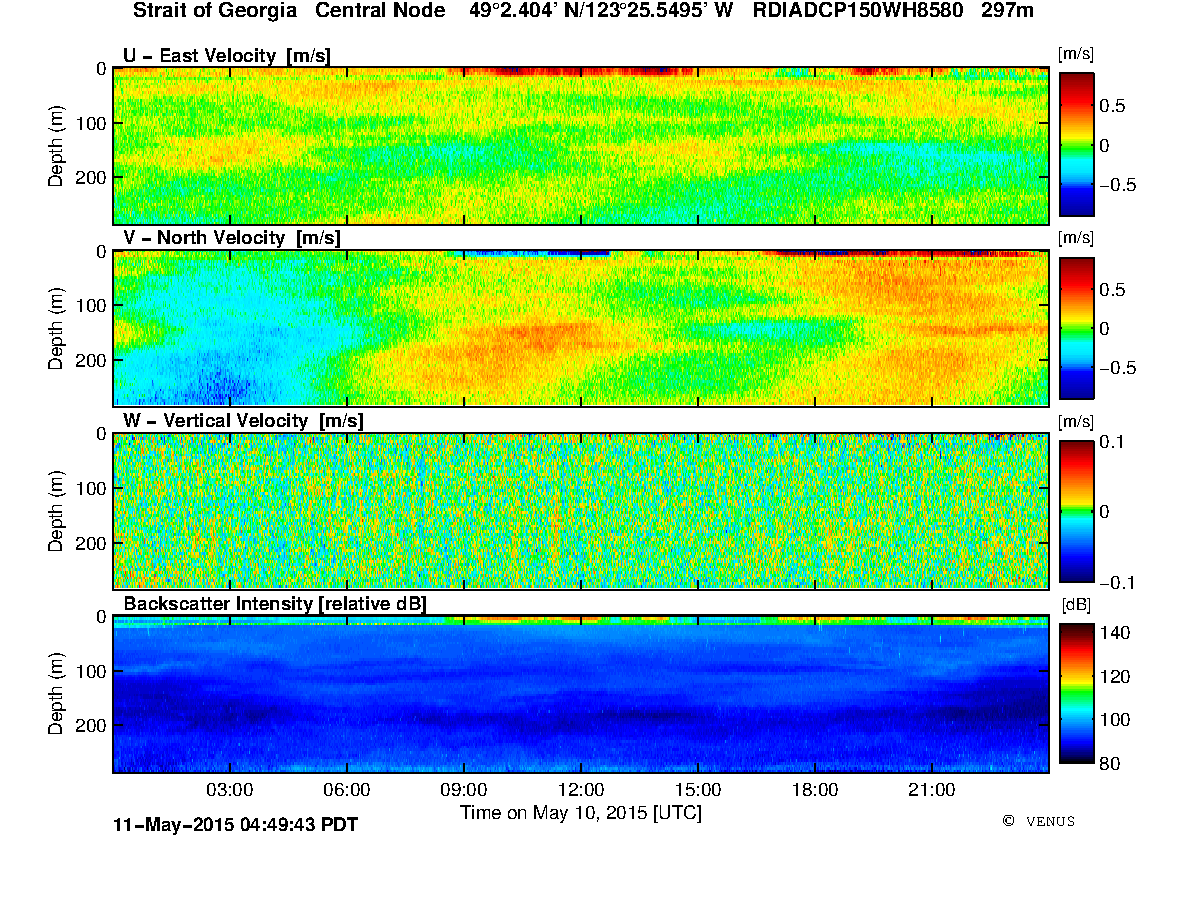

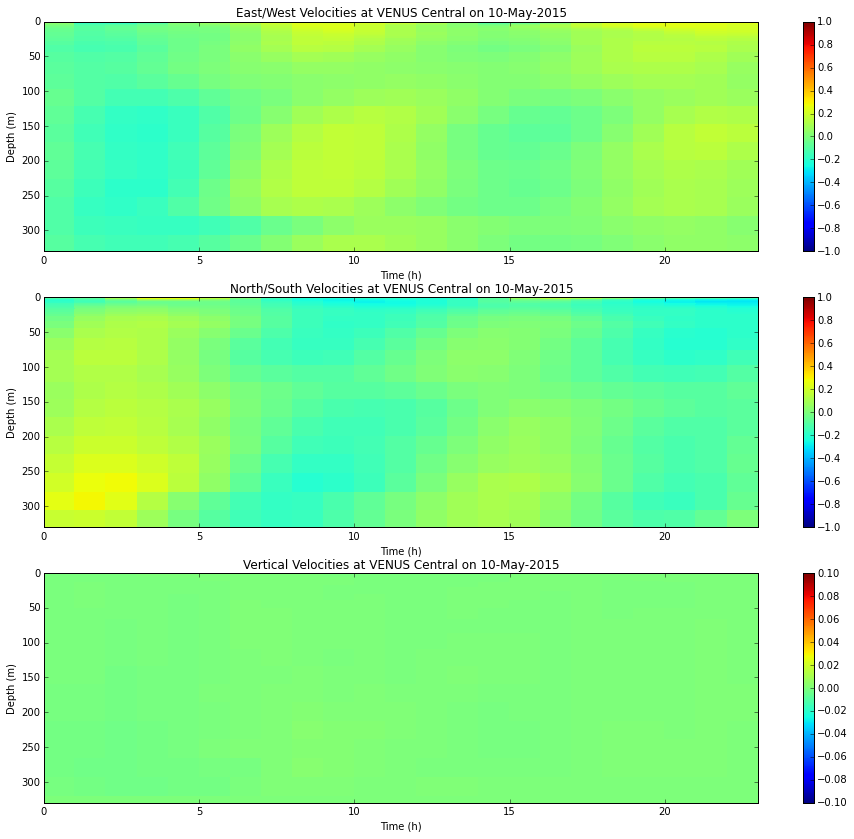

In [65]:
plot_vel_NE_compare('Central', uvel, vvel, wvel,imagec, imagee)

The model velocities are  much smaller than the ones detected by the ADCP.
The comparisons with the ADCP may help as a guidance for the magnitude but from Rich and Mark's research we know the instuments North and East cannot be trusted.

##Model velocities
This fucntion could be used to upload the model velocities to the Salish Sea website daily.

In [66]:
def plot_vel_NE(station,uvel, vvel, wvel):
    """Function to plot the model's North/South and East/West velocities hourly averages. 
    Station specifies 'East' or 'Central'
    uvel, vvel and wvel are the Datasets of the filename with the hourly averages of many variables."""
    
    u_u= uvel.variables['vozocrtx']
    v_v= vvel.variables['vomecrty']
    w_w= wvel.variables['vovecrtz']
    dep_t= vvel.variables['depthv']
    dep_w=wvel.variables['depthw']

    u_E, v_N, i, j, dep_s=unstag_rot(u_u, v_v,station)

    fig, (axu, axv, axw)=plt.subplots(3,1,figsize=(16,14))

    #viz_tools.set_aspect(axu)
    timestamp=nc_tools.timestamp(uvel,0)
    cmap=plt.get_cmap('jet')
    axu.invert_yaxis()
    mesh=axu.pcolormesh(np.arange(24),dep_t[:], u_E.transpose(),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axu)
    axu.set_ylim([dep_s,0])
    axu.set_xlim([0,23])
    axu.set_xlabel('Time (h)')
    axu.set_ylabel('Depth (m)')
    axu.set_title('East/West Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

    axv.invert_yaxis()
    mesh=axv.pcolormesh(np.arange(24),dep_t[:], v_N.transpose(),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axv)
    axv.set_ylim([dep_s,0])
    axv.set_xlim([0,23])
    axv.set_xlabel('Time (h)')
    axv.set_ylabel('Depth (m)')
    axv.set_title('North/South Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

    axw.invert_yaxis()
    mesh=axw.pcolormesh(np.arange(24), dep_w[:], w_w[:,:,j,i].transpose(), cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axw)
    axw.set_ylim([dep_s,0])
    axw.set_xlim([0,23])
    axw.set_xlabel('Time (h)')
    axw.set_ylabel('Depth (m)')
    axw.set_title('Vertical Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY'))) 

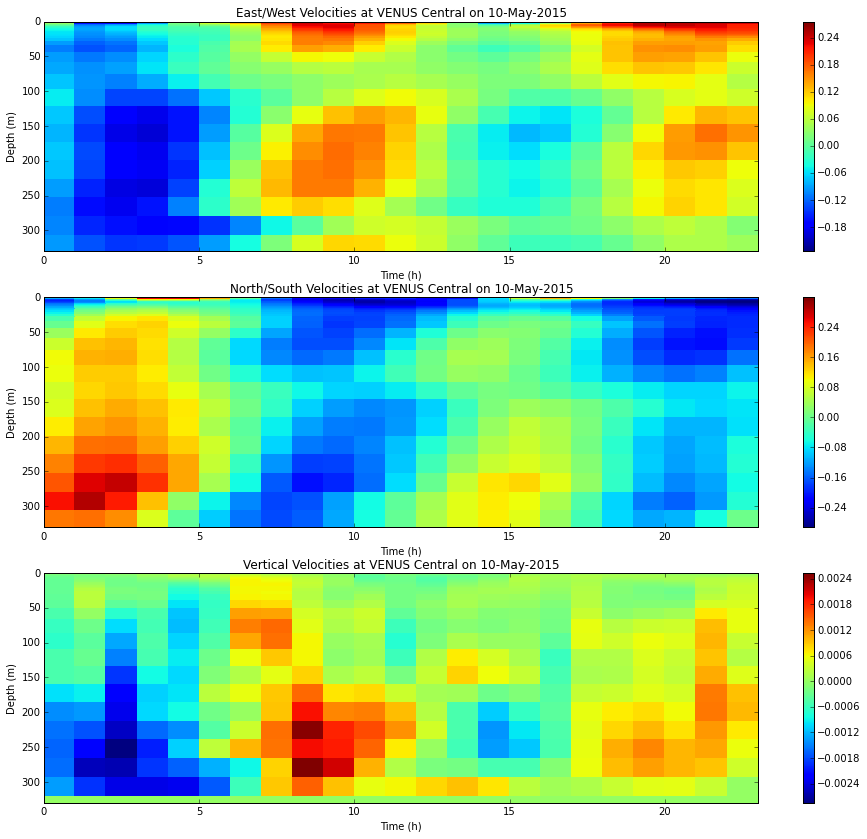

In [67]:
plot_vel_NE('Central', uvel, vvel, wvel)

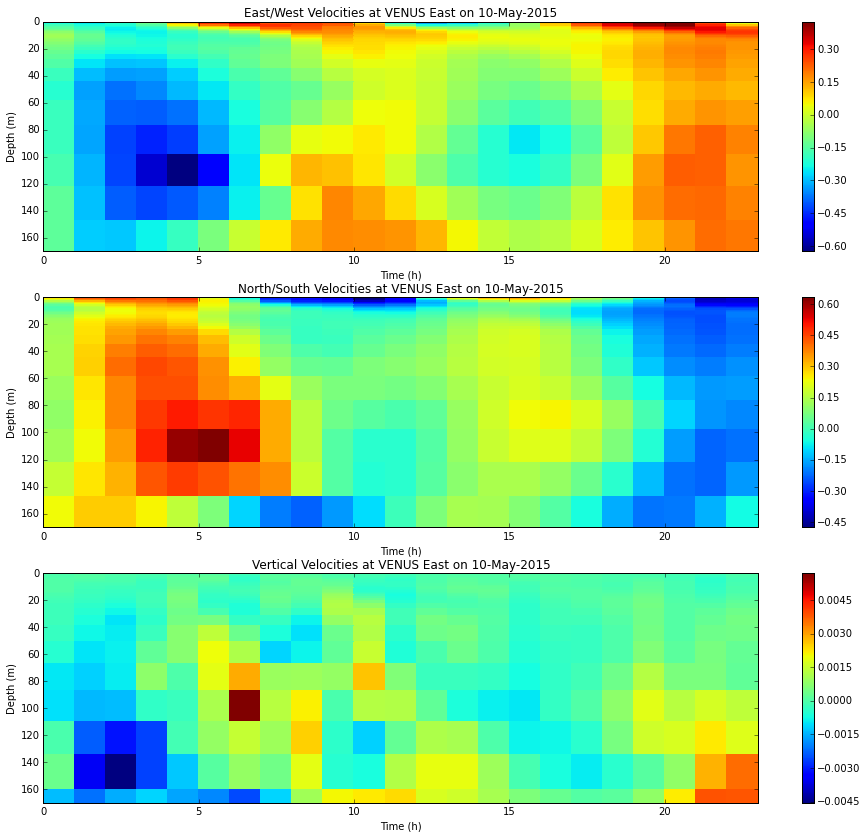

In [68]:
plot_vel_NE('East', uvel, vvel, wvel)